## Import Python Libraries

In [1]:
import os
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn import preprocessing, metrics
import geopandas as gpd
import requests
import zipfile
import io

%matplotlib inline
from matplotlib import pyplot as plt

## Bring in the Data

### Download a shapefile of county boundaries from Census for the US and load it into a GeoPandas DataFrame

In [2]:
def download_shapefile(directory):
    """
    Download county boundaries from census.gov ftp site. Unzips file and loads it into a geoPandas dataframe
    
    """          
    map_url = "https://www2.census.gov/geo/tiger/TIGER2017/COUNTY/tl_2017_us_county.zip"
    #print('Downloading shapefile...')
        
    # Split on the rightmost / and take everything on the right side of that
    name = map_url.rsplit('/', 1)[-1]
    
    # Remove newline characters from URL
    filename = name.replace("\n", "")
        
    file_zip = os.path.join(directory,filename)
    
    r = requests.get(map_url)
    with open(file_zip, "wb") as code:
        code.write(r.content)
    
    z=zipfile.ZipFile(file_zip).extractall(directory)
        
    nation_file_shp = file_zip.replace(".zip",".shp")
        
    # Read into geoPandas Dataframe   
    nation = gpd.read_file(nation_file_shp)
    
    return nation

In [3]:
us_counties = download_shapefile("C:\\Projects\\junk\\Cluster")

## Select State of interest for analysis to using FIPS codes to make a new GeoDataFrame

In [8]:
def select_state(fips, nation):
    """
    Creates new GeoDataFrame based on FIPS code
    
    fips:the 2-digit FIPS code for your state you of interest
    nation: GeoDataFrame of census counties
    """
      
    counties = nation.loc[nation['STATEFP'] == '{0}'.format(fips)].squeeze() 
    counties = counties.rename(columns={'GEOID': 'geoId'})
    counties = counties.rename(columns={'NAMELSAD': 'name'})
    
    #return counties
    return counties

In [9]:
counties_gdf = select_state('09', us_counties)

In [10]:
counties_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,geoId,NAME,name,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
90,09,007,00212797,09007,Middlesex,Middlesex County,06,H4,G4020,278,25540,None,N,956493768,180679144,+41.4330028,-072.5227802,"POLYGON ((-72.653672 41.438125, -72.6541929999..."
667,09,011,00212799,09011,New London,New London County,06,H4,G4020,278,35980,None,N,1722708285,276666169,+41.4726517,-072.1086339,"POLYGON ((-72.32451 41.61857, -72.324669 41.61..."
1138,09,009,00212798,09009,New Haven,New Haven County,06,H4,G4020,408,35300,None,N,1565653728,667092277,+41.3497173,-072.9002037,"POLYGON ((-73.147555 41.367696, -73.148523 41...."
1228,09,013,00212668,09013,Tolland,Tolland County,06,H4,G4020,278,25540,None,N,1062807475,17549693,+41.8580807,-072.3409779,"POLYGON ((-72.49681 41.860616, -72.50104499999..."
1395,09,003,00212338,09003,Hartford,Hartford County,06,H4,G4020,278,25540,None,N,1903983151,40128067,+41.8060534,-072.7329157,"POLYGON ((-72.94902399999999 41.806431, -72.94..."



### Use request.get to load data requested from API into a Response object. Use Requests builtin JSON decoder to read JSON data and load it into a Pandas dataframe.

In [11]:
def create_dataframe(fips,early_year,late_year):
    """
    Submits request for data to the API and creates formatted pandas dataframe for use with clustering algorithms
    
    fips = string defining the 2-digit FIPS code for your state you of interest
    early_year = string defining the 1st date of change period (1996, 2001, 2006 or 2010)
    late_year = string defining the 2nd date of change period (1996, 2001, 2006 or 2010)
    """
    # Format inputs for url
    fips = "'{}'".format(fips)
    early_year = "'{}'".format(early_year)
    late_year = "'{}'".format(late_year)
    
    #API request for Land Cover data in JSON format
    url = "https://coast.noaa.gov/opendata/LandCover/api/v1/distributionOfChangeGainsLossesByLandcovers?$filter=startswith(geoId, {0}) and length(geoId) eq 5 and earlyYear eq {1} and lateYear eq {2}".format(fips, early_year, late_year)
    
    r = requests.get(url, headers={'Accept': 'application/json'})
    data = r.json()
    lca_df = pd.DataFrame(data['value'])
    
    # Set index to the FIPS code and drop Early and Late Year Fields
    lca_df_index = lca_df.set_index('geoId').drop(['earlyYear', 'lateYear'], axis=1)
    
    return lca_df_index


In [12]:
CT_2001_2010 = create_dataframe('09',2001,2010)

In [13]:
CT_2001_2010.head()

,AgrAreaGain,AgrAreaLoss,BarAreaGain,BarAreaLoss,EmwAreaGain,EmwAreaLoss,ForAreaGain,ForAreaLoss,GrsAreaGain,GrsAreaLoss,...,LIDAreaGain,LIDAreaLoss,OSDAreaGain,OSDAreaLoss,SscbAreaGain,SscbAreaLoss,WdwAreaGain,WdwAreaLoss,WtrAreaGain,WtrAreaLoss
geoId,,,,,,,,,,,,,,,,,,,,,
09001,0.31,-1.64,0.43,-0.20,0.06,-0.16,0.67,-7.58,0.41,-0.30,...,4.33,-0.49,3.61,-1.77,0.49,-0.86,0.05,-0.36,0.05,-0.20
09003,0.71,-6.39,0.48,-0.19,0.14,-0.19,0.23,-10.56,1.06,-0.17,...,6.25,-0.45,6.91,-1.83,0.95,-1.95,0.08,-0.81,0.06,-0.26
09005,0.60,-1.03,0.31,-0.06,0.29,-0.10,0.20,-3.89,1.36,-0.22,...,0.77,-0.06,0.97,-0.20,0.84,-0.36,0.13,-0.22,0.12,-0.28
09007,0.30,-0.92,0.30,-0.09,0.12,-0.09,0.11,-4.09,0.24,-0.16,...,1.72,-0.11,1.37,-0.37,0.69,-0.47,0.05,-0.32,0.08,-0.15
09009,0.36,-1.92,0.49,-0.27,0.38,-0.13,0.20,-8.45,0.75,-0.59,...,4.05,-0.43,3.93,-1.55,0.71,-1.01,0.06,-0.42,0.15,-0.48


### Create Pandas DataFrame with County Names and Fips Codes from GeoPandas DataFrame

In [22]:
def create_fips_table(dataframe):
    """
    Creates table of FIPS codes and county names for joining to Land Cover DataFrame
    
    dataframe: Geopandas dataframe of State of interest
    
    """
    
    county_attributes = pd.DataFrame(dataframe)
    fips_names = county_attributes[['geoId','name']]
    fips_names.columns = ['geoId','name']
    fips_names = fips_names.set_index('geoId')
    
    return fips_names

In [23]:
fips_df = create_fips_table(counties_gdf)

### Merge County FIPS/Names dataframe with LC Change Dataframes

In [24]:
def merge_dataframes(dataframe,fips_names_df):
    """
    Merges county names to land cover dataframe based on FIPS code
    
    dataframe: DataFrame with Land Cover change data
    fips_names_df: DataFrame with FIPS codes and County Names
    """
    fips_index_df = pd.merge(dataframe, fips_names_df, left_index=True,right_index=True)
    name_index_df=fips_index_df.set_index('name')
    
    return name_index_df

In [25]:
CT_2001_2010_index = merge_dataframes(CT_2001_2010, fips_df)

In [26]:
CT_2001_2010_index.head()

,AgrAreaGain,AgrAreaLoss,BarAreaGain,BarAreaLoss,EmwAreaGain,EmwAreaLoss,ForAreaGain,ForAreaLoss,GrsAreaGain,GrsAreaLoss,...,LIDAreaGain,LIDAreaLoss,OSDAreaGain,OSDAreaLoss,SscbAreaGain,SscbAreaLoss,WdwAreaGain,WdwAreaLoss,WtrAreaGain,WtrAreaLoss
name,,,,,,,,,,,,,,,,,,,,,
Fairfield County,0.31,-1.64,0.43,-0.20,0.06,-0.16,0.67,-7.58,0.41,-0.30,...,4.33,-0.49,3.61,-1.77,0.49,-0.86,0.05,-0.36,0.05,-0.20
Hartford County,0.71,-6.39,0.48,-0.19,0.14,-0.19,0.23,-10.56,1.06,-0.17,...,6.25,-0.45,6.91,-1.83,0.95,-1.95,0.08,-0.81,0.06,-0.26
Litchfield County,0.60,-1.03,0.31,-0.06,0.29,-0.10,0.20,-3.89,1.36,-0.22,...,0.77,-0.06,0.97,-0.20,0.84,-0.36,0.13,-0.22,0.12,-0.28
Middlesex County,0.30,-0.92,0.30,-0.09,0.12,-0.09,0.11,-4.09,0.24,-0.16,...,1.72,-0.11,1.37,-0.37,0.69,-0.47,0.05,-0.32,0.08,-0.15
New Haven County,0.36,-1.92,0.49,-0.27,0.38,-0.13,0.20,-8.45,0.75,-0.59,...,4.05,-0.43,3.93,-1.55,0.71,-1.01,0.06,-0.42,0.15,-0.48


### Create dendrogram from LC Change dataframe and use county names as the label

In [27]:
def make_dendrogram(cluster_df):
    
    mergings = linkage(cluster_df, method='complete')
    
    plt.figure(figsize=(25,15))
    plt.title('Hierarchical Clustering Dendrogram')
    
    dendrogram(mergings, labels=cluster_df.index, leaf_rotation=90, leaf_font_size=12)
    
    plt.show()
    
    return mergings

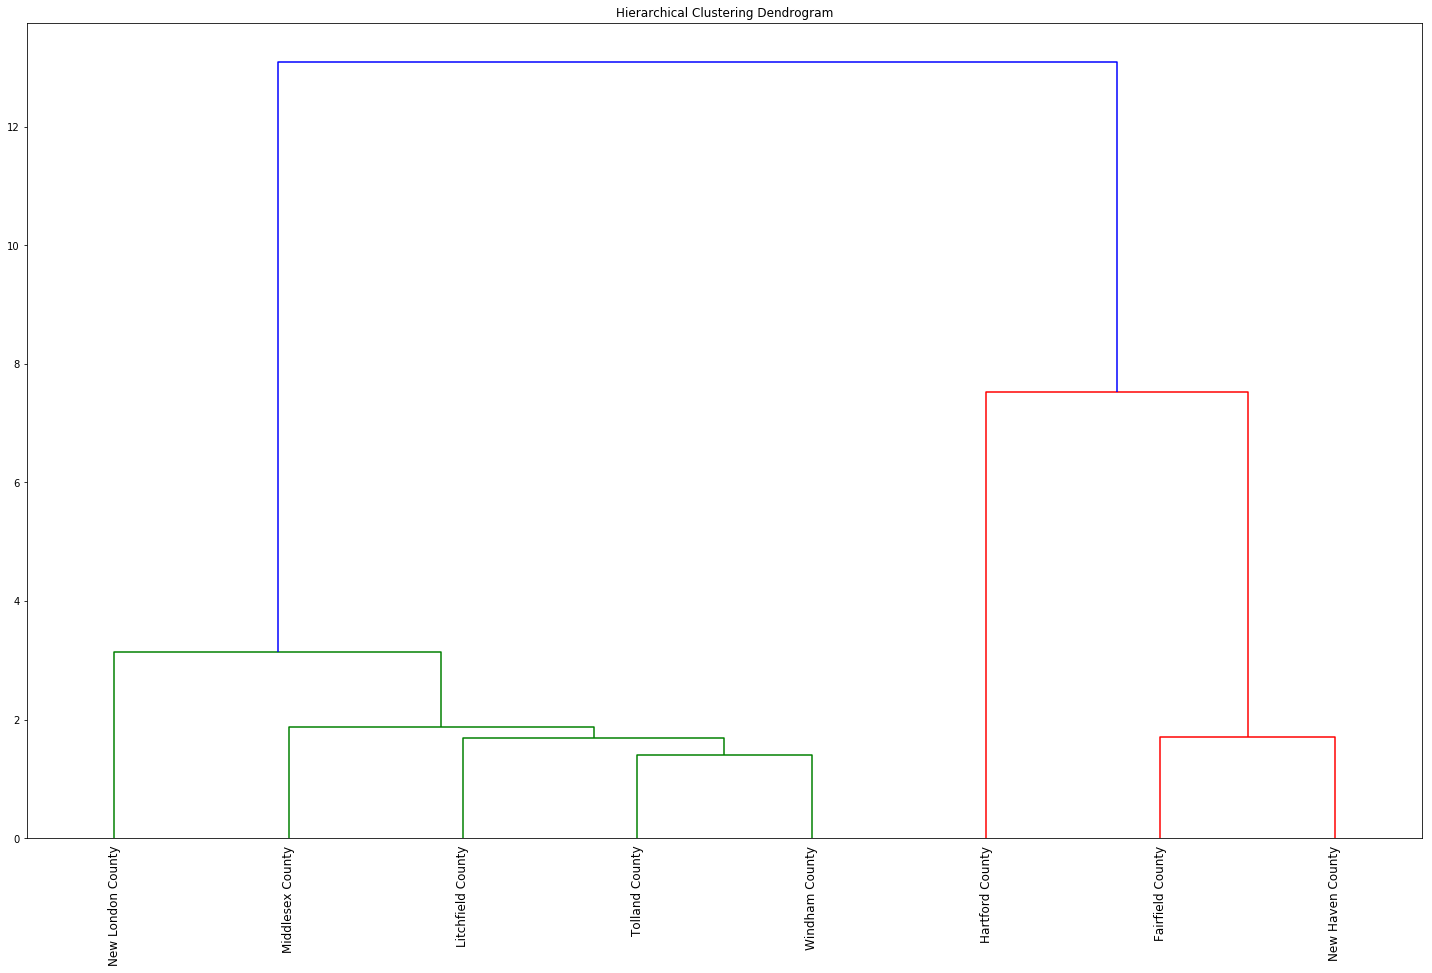

In [28]:
dendro_plot =make_dendrogram(cluster_df=CT_2001_2010_index)

### Extract the labels at a specified distence on the Dendrogram and join them to the counties

In [29]:
def extract_labels(dendrogram, distance,cluster_df):
    """
    Extract the lables for each County from the dendrogram
    
    dendrogram: Dendrogram output from previous function
    distance: Number representing the distance (Y axis) on the histogram you would like to extract the clusters from
    cluster_df: Pandas DataFrame clustering was perfromed on
    
    """
    
    # Use fcluster to extract labels: labels
    labels = fcluster(dendrogram,distance,criterion='distance')
    labels_df = pd.DataFrame({'labels':labels}, index=cluster_df.index)
    
    return labels_df

In [30]:
cluster_labels = extract_labels(dendro_plot, 5, CT_2001_2010_index)

### Join Cluster Labels to GeoDataFrame to view them spatially

In [31]:
def labels_to_gdf(labels_df,counties):
    """
    Extract the lables for each County from the dendrogram
    
    labels_df: Pandas DataFrame with cluster labels for each county
    counties: Pandas GeoDataFrame with County boundaries 
    
    """
    
    counties_cluster=counties.join(labels_df, on='name')
    
    return counties_cluster

In [32]:
clusters_gdf = labels_to_gdf(cluster_labels,counties_gdf)

### Map the Clusters

In [33]:
def map_clusters(clusters_gdf):
    """
    Takes labels from hierarchical clustering and joins them to Geopandas DataFrame
    
    dataframe: Name of pandas dataframe being used for cluster analysis
    """
    cluster_plot = clusters_gdf.plot(figsize=(25, 25), column='labels', legend=True)
    cluster_plot.set_axis_off()

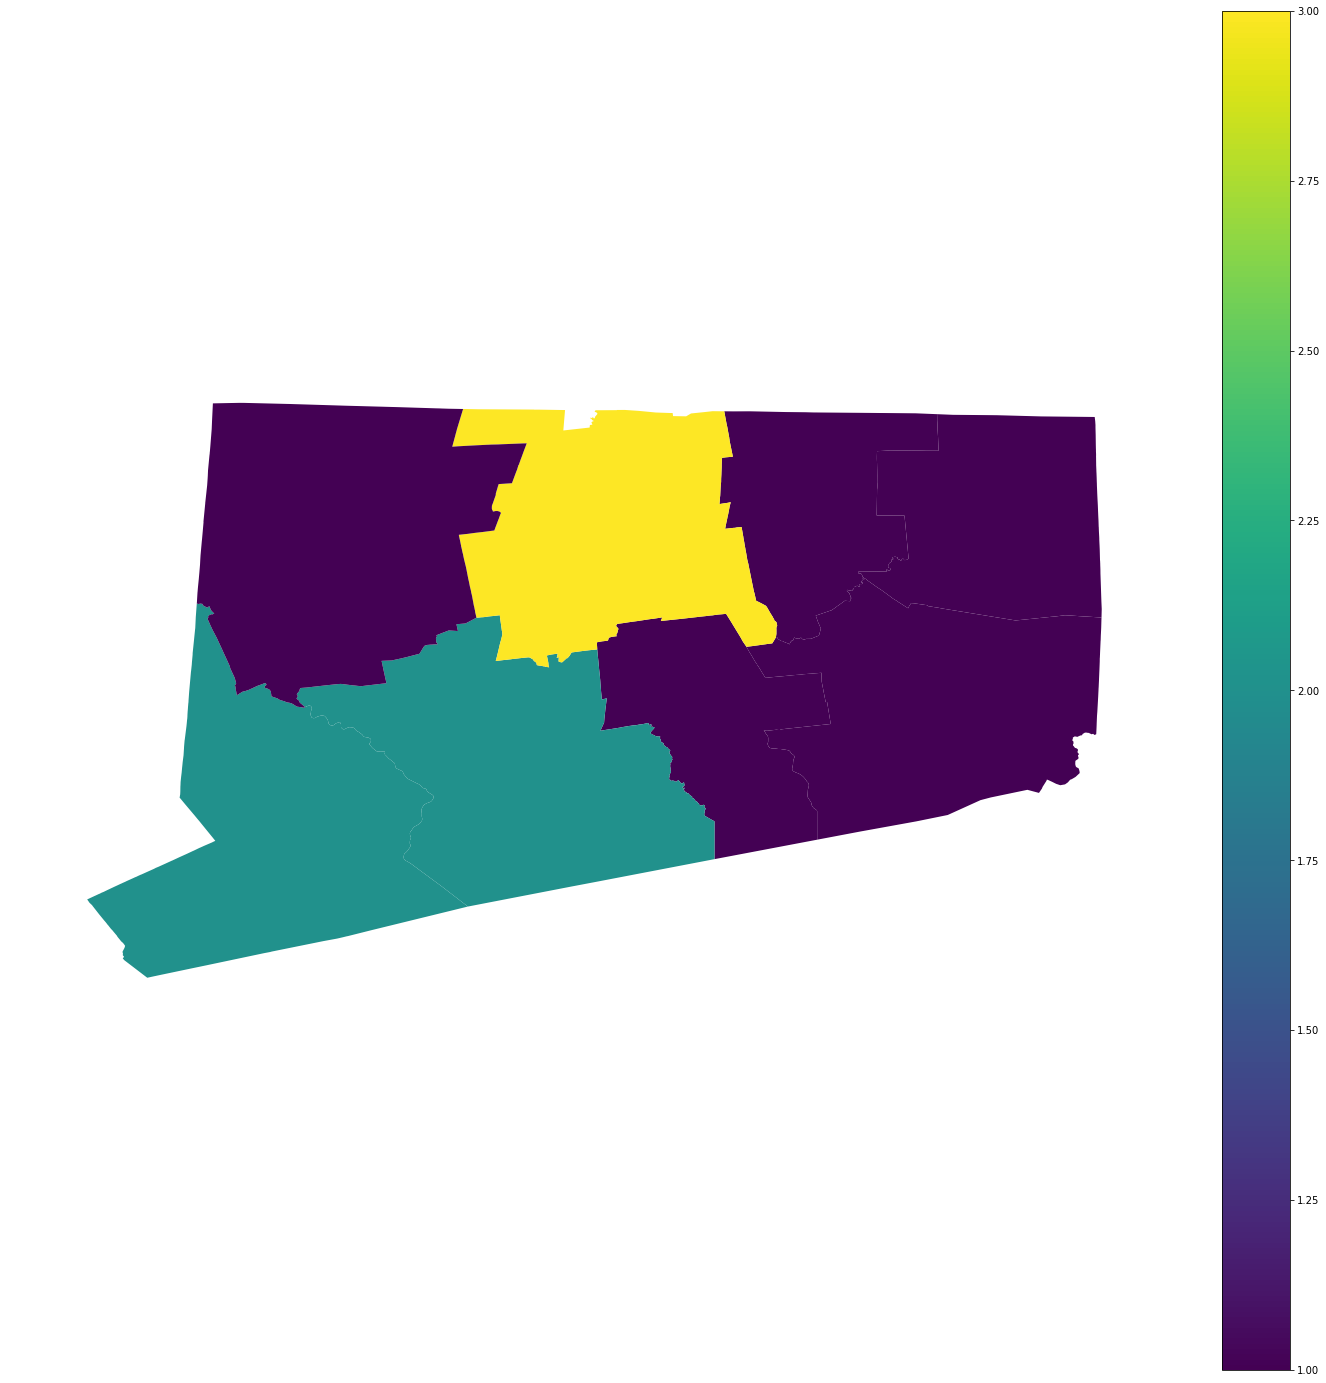

In [34]:
map_clusters(clusters_gdf)